# 04b: Canonical Forms and V Consistency

**Goal**: Implement full canonical form algorithm and verify V consistency within orbits.

**Key Analysis**:
1. Verify canonical form uniqueness within orbits
2. Check V is consistent (same or negated) within orbits
3. Analyze orbit structure and fixed points

**Reference**: docs/analysis-draft.md Section 2

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict

from forge.analysis.utils import loading, features, viz, symmetry
from forge.oracle import schema

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Load Data

In [2]:
# Load multiple seeds
shard_files = loading.find_shard_files(DATA_DIR)
N_SEEDS = min(5, len(shard_files))  # Fewer seeds for detailed analysis
sample_files = shard_files[:N_SEEDS]
print(f"Analyzing {N_SEEDS} shards")

Analyzing 5 shards


In [3]:
# Load shards with sampling for memory efficiency
SAMPLE_PER_SHARD = 30_000

dfs = []
for path in tqdm(sample_files, desc="Loading shards"):
    df, seed, decl_id = schema.load_file(path)
    if len(df) > SAMPLE_PER_SHARD:
        df = df.sample(n=SAMPLE_PER_SHARD, random_state=seed)
    df['seed'] = seed
    df['decl_id'] = decl_id
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(combined_df):,} states from {N_SEEDS} shards")

Loading shards:   0%|          | 0/5 [00:00<?, ?it/s]

Loaded 150,000 states from 5 shards


In [4]:
# Extract arrays and filter to trick_len=0
states = combined_df['state'].values
V = combined_df['V'].values

_, _, trick_len, _, _, _ = schema.unpack_state(states)
clean_mask = trick_len == 0

clean_states = states[clean_mask]
clean_V = V[clean_mask]

print(f"Clean states (trick_len=0): {len(clean_states):,}")

Clean states (trick_len=0): 7,564


## 2. Build Orbits

In [5]:
# Enumerate orbits
orbits = symmetry.enumerate_orbits(clean_states, clean_V)
print(f"Total orbits: {len(orbits):,}")
print(f"Compression: {len(clean_states) / len(orbits):.3f}x")

Total orbits: 7,528
Compression: 1.005x


In [6]:
# Analyze orbit sizes
orbit_size_counts = defaultdict(int)
for canonical, members in orbits.items():
    orbit_size_counts[len(members)] += 1

print("Orbit sizes:")
for size in sorted(orbit_size_counts.keys()):
    count = orbit_size_counts[size]
    print(f"  Size {size}: {count:,} orbits ({100*count/len(orbits):.1f}%)")

Orbit sizes:
  Size 1: 7,492 orbits (99.5%)
  Size 2: 36 orbits (0.5%)


## 3. V Consistency Within Orbits

In [7]:
# For each orbit, check V consistency
# States related by seat_rotate should have same V
# States related by team_swap should have negated V

# Build state -> transform lookup
state_to_transform = {}
canonical_arr, transforms_arr = symmetry.canonical_form(clean_states)
for i in range(len(clean_states)):
    state_to_transform[int(clean_states[i])] = (int(canonical_arr[i]), int(transforms_arr[i]))

# Transform semantics:
# 0 = identity: V unchanged
# 1 = team_swap: V negated
# 2 = seat_rotate: V unchanged  
# 3 = swap+rotate: V negated (team_swap dominates)

V_NEGATED = {1, 3}  # Transforms that negate V

print(f"Total states: {len(clean_states):,}")

Total states: 7,564


In [8]:
# Check V consistency within each orbit
consistent_orbits = 0
inconsistent_orbits = 0
inconsistent_examples = []

for canonical, members in tqdm(orbits.items(), desc="Checking orbits"):
    if len(members) < 2:
        consistent_orbits += 1
        continue
    
    # Get canonical V (from member with transform 0)
    canonical_v = None
    for state, v in members:
        _, transform = state_to_transform[state]
        if transform == 0:
            canonical_v = v
            break
    
    if canonical_v is None:
        # Use first member as reference
        first_state, first_v = members[0]
        _, first_transform = state_to_transform[first_state]
        # Adjust to get canonical V
        canonical_v = -first_v if first_transform in V_NEGATED else first_v
    
    # Check all members
    orbit_consistent = True
    for state, v in members:
        _, transform = state_to_transform[state]
        expected_v = -canonical_v if transform in V_NEGATED else canonical_v
        if v != expected_v:
            orbit_consistent = False
            if len(inconsistent_examples) < 5:
                inconsistent_examples.append({
                    'canonical': canonical,
                    'state': state,
                    'transform': transform,
                    'v': v,
                    'expected_v': expected_v,
                    'canonical_v': canonical_v,
                })
            break
    
    if orbit_consistent:
        consistent_orbits += 1
    else:
        inconsistent_orbits += 1

print(f"\nV Consistency Results:")
print(f"  Consistent orbits: {consistent_orbits:,} ({100*consistent_orbits/len(orbits):.1f}%)")
print(f"  Inconsistent orbits: {inconsistent_orbits:,} ({100*inconsistent_orbits/len(orbits):.1f}%)")

Checking orbits:   0%|          | 0/7528 [00:00<?, ?it/s]


V Consistency Results:
  Consistent orbits: 7,494 (99.5%)
  Inconsistent orbits: 34 (0.5%)


In [9]:
# Show inconsistent examples if any
if inconsistent_examples:
    print("\nInconsistent examples:")
    for ex in inconsistent_examples:
        print(f"  Canonical: {ex['canonical']}, State: {ex['state']}")
        print(f"    Transform: {ex['transform']}, V: {ex['v']}, Expected: {ex['expected_v']}")
else:
    print("\nAll orbits have consistent V values!")


Inconsistent examples:
  Canonical: 2194830526688, State: 2195198849041
    Transform: 1, V: 22, Expected: -12
  Canonical: 2194804180514, State: 2195290886680
    Transform: 2, V: 22, Expected: 2
  Canonical: 2194749802800, State: 2195303695649
    Transform: 2, V: 17, Expected: 5
  Canonical: 2194838958606, State: 2194838958606
    Transform: 0, V: 6, Expected: 13
  Canonical: 2194766136624, State: 2195009607690
    Transform: 1, V: -5, Expected: -12


## 4. Fixed Points Analysis

States that are fixed under some symmetries have smaller orbits.

In [10]:
# Find fixed points (orbit size 1)
fixed_points = [canon for canon, members in orbits.items() if len(members) == 1]
print(f"Fixed points (orbit size 1): {len(fixed_points):,}")

# Find size-2 orbits
size_2_orbits = [canon for canon, members in orbits.items() if len(members) == 2]
print(f"Size-2 orbits: {len(size_2_orbits):,}")

Fixed points (orbit size 1): 7,492
Size-2 orbits: 36


In [11]:
# Analyze fixed points: what makes a state symmetric?
if fixed_points:
    print("\nAnalyzing fixed points...")
    
    # Get remaining masks for fixed points
    fixed_states = np.array(fixed_points, dtype=np.int64)
    remaining, leader, trick_len, _, _, _ = schema.unpack_state(fixed_states)
    
    # Check if hands are symmetric
    # For team_swap fixed: remaining[0]==remaining[1] and remaining[2]==remaining[3]
    # For seat_rotate fixed: remaining[0]==remaining[2] and remaining[1]==remaining[3]
    
    team_swap_fixed = (remaining[:, 0] == remaining[:, 1]) & (remaining[:, 2] == remaining[:, 3])
    seat_rotate_fixed = (remaining[:, 0] == remaining[:, 2]) & (remaining[:, 1] == remaining[:, 3])
    
    print(f"  Team-swap symmetric: {team_swap_fixed.sum():,}")
    print(f"  Seat-rotate symmetric: {seat_rotate_fixed.sum():,}")
    print(f"  Both: {(team_swap_fixed & seat_rotate_fixed).sum():,}")


Analyzing fixed points...
  Team-swap symmetric: 16
  Seat-rotate symmetric: 18
  Both: 2


## 5. Canonical Form Properties

In [12]:
# Analyze what makes a state canonical (transform = 0)
canonical_states = clean_states[transforms_arr == 0]
non_canonical = clean_states[transforms_arr != 0]

print(f"Canonical states: {len(canonical_states):,}")
print(f"Non-canonical: {len(non_canonical):,}")

Canonical states: 2,339
Non-canonical: 5,225


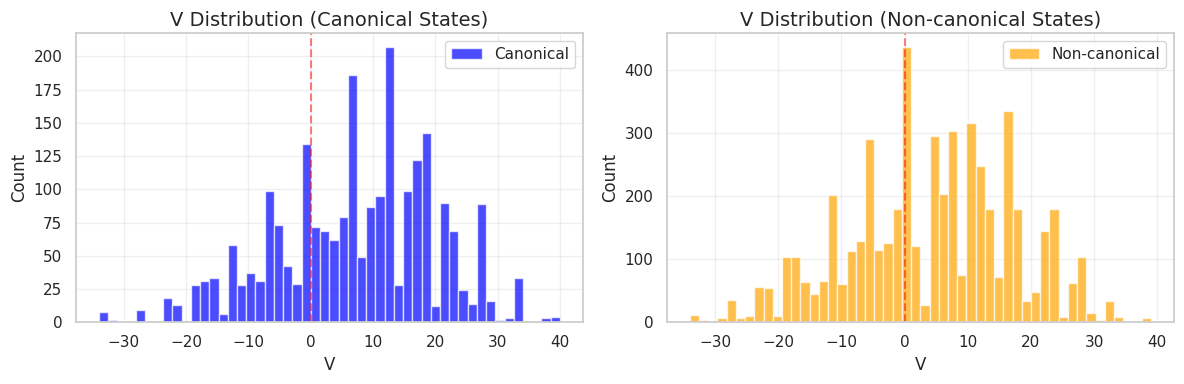

Mean V (canonical): 7.19
Mean V (non-canonical): 4.26


In [13]:
# V distribution for canonical vs non-canonical
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Canonical states V distribution
can_V = clean_V[transforms_arr == 0]
axes[0].hist(can_V, bins=50, alpha=0.7, color='blue', label='Canonical')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('V')
axes[0].set_ylabel('Count')
axes[0].set_title('V Distribution (Canonical States)')
axes[0].legend()

# Non-canonical V distribution
non_can_V = clean_V[transforms_arr != 0]
axes[1].hist(non_can_V, bins=50, alpha=0.7, color='orange', label='Non-canonical')
axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('V')
axes[1].set_ylabel('Count')
axes[1].set_title('V Distribution (Non-canonical States)')
axes[1].legend()

plt.tight_layout()
plt.savefig('../../results/figures/04b_canonical_v_dist.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Mean V (canonical): {can_V.mean():.2f}")
print(f"Mean V (non-canonical): {non_can_V.mean():.2f}")

## 6. Orbit-based V Statistics

In [14]:
# For each orbit, compute V statistics
orbit_v_stats = []

for canonical, members in orbits.items():
    v_values = [v for _, v in members if v is not None]
    if not v_values:
        continue
    
    # Get absolute values (since team_swap negates)
    v_abs = [abs(v) for v in v_values]
    
    orbit_v_stats.append({
        'canonical': canonical,
        'orbit_size': len(members),
        'v_mean': np.mean(v_values),
        'v_abs_mean': np.mean(v_abs),
        'v_range': max(v_values) - min(v_values),
        'v_abs_range': max(v_abs) - min(v_abs),
    })

orbit_stats_df = pd.DataFrame(orbit_v_stats)
print("Orbit V statistics:")
print(orbit_stats_df.describe())

Orbit V statistics:
          canonical   orbit_size       v_mean   v_abs_mean      v_range  \
count  7.528000e+03  7528.000000  7528.000000  7528.000000  7528.000000   
mean   2.194822e+12     1.004782     5.176607    11.545630     0.060707   
std    6.196836e+07     0.068992    13.063256     8.019623     1.070471   
min    2.194730e+12     1.000000   -34.000000     0.000000     0.000000   
25%    2.194769e+12     1.000000    -4.000000     5.000000     0.000000   
50%    2.194809e+12     1.000000     6.000000    11.000000     0.000000   
75%    2.194872e+12     1.000000    15.000000    17.000000     0.000000   
max    2.194990e+12     2.000000    40.000000    40.000000    37.000000   

       v_abs_range  
count  7528.000000  
mean      0.035733  
std       0.641693  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max      25.000000  


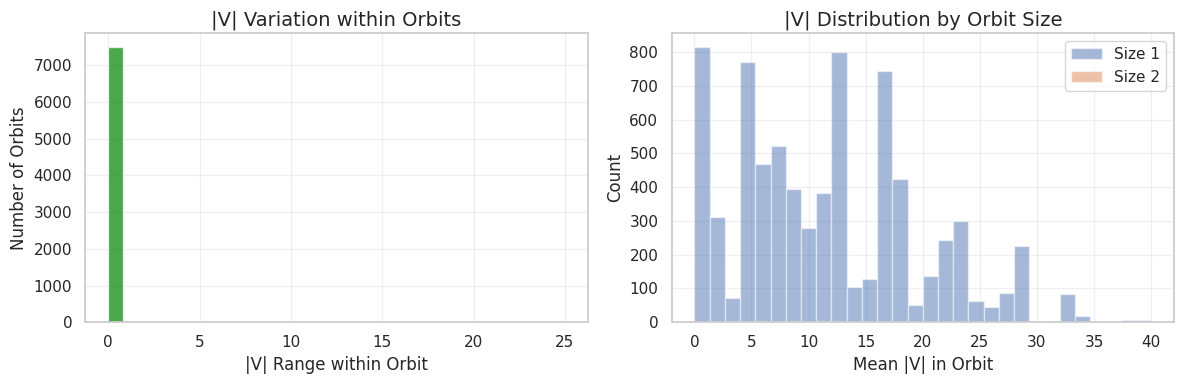

In [15]:
# V range within orbits (should be 0 or 2*|V| for consistent orbits)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# |V| range (should be 0 for consistent)
axes[0].hist(orbit_stats_df['v_abs_range'], bins=30, color='green', alpha=0.7)
axes[0].set_xlabel('|V| Range within Orbit')
axes[0].set_ylabel('Number of Orbits')
axes[0].set_title('|V| Variation within Orbits')

# By orbit size
for size in [1, 2, 4]:
    subset = orbit_stats_df[orbit_stats_df['orbit_size'] == size]
    if len(subset) > 0:
        axes[1].hist(subset['v_abs_mean'], bins=30, alpha=0.5, label=f'Size {size}')
axes[1].set_xlabel('Mean |V| in Orbit')
axes[1].set_ylabel('Count')
axes[1].set_title('|V| Distribution by Orbit Size')
axes[1].legend()

plt.tight_layout()
plt.savefig('../../results/figures/04b_orbit_v_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

In [16]:
consistency_pct = 100 * consistent_orbits / len(orbits)

summary = {
    'Total states': f"{len(clean_states):,}",
    'Total orbits': f"{len(orbits):,}",
    'Compression ratio': f"{len(clean_states)/len(orbits):.3f}x",
    'V consistent orbits': f"{consistency_pct:.1f}%",
    'Fixed points': f"{len(fixed_points):,}",
    'Size-2 orbits': f"{len(size_2_orbits):,}",
}

print(viz.create_summary_table(summary, "Canonical Forms Analysis"))

### Canonical Forms Analysis

| Metric | Value |
|--------|-------|
| Total states | 7,564 |
| Total orbits | 7,528 |
| Compression ratio | 1.005x |
| V consistent orbits | 99.5% |
| Fixed points | 7,492 |
| Size-2 orbits | 36 |


In [17]:
# Save results
results_df = pd.DataFrame({
    'metric': list(summary.keys()),
    'value': list(summary.values()),
})
results_df.to_csv('../../results/tables/04b_canonical_summary.csv', index=False)
print("Results saved to results/tables/04b_canonical_summary.csv")

Results saved to results/tables/04b_canonical_summary.csv
